# Analysis of edits

## Data import

Detailed edit data are located in detailed_data folder in three files, one for each of the topics analysed.

In [1]:
## Setup + data import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import itertools

wikiData_US = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-11-03.csv")
wikiData_US['topic'] = 'US_Civil_War'

wikiData_UA = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-13-22-44.csv")
wikiData_UA['topic'] = 'Ukraine'

wikiData_IP = pd.read_csv("../data/detailed_data/detailedEdits_2024-06-14-11-41.csv")
wikiData_IP['topic'] = 'Israel/Palestine'


wikiData_all = pd.concat([wikiData_UA, wikiData_US, wikiData_IP])[['user', 'timestamp', 'size', 'reverted', 'reversion', 'topic', 'article', 'language', 'total_edits', 'article_edits']].drop_duplicates()
wikiData_all['ratio_edits'] = (wikiData_all['article_edits']/wikiData_all['total_edits']).replace(np.inf, 1.01)

wikiData_all['timestamp'] = pd.to_datetime(wikiData_all['timestamp'])
wikiData_all['month'] = wikiData_all['timestamp'].dt.month
wikiData_all['year'] = wikiData_all['timestamp'].dt.year

wikiData_all[wikiData_all['reversion'] == 1].sort_values('timestamp').head()

,user,timestamp,size,reverted,reversion,topic,article,language,total_edits,article_edits,ratio_edits,month,year
92202,Triggerhippie4,2018-01-05 12:10:02,84050,0,1,Israel/Palestine,Hebrew_language,en,20341,43.0,0.002114,1,2018
12022,Karl.i.biased,2018-01-06 01:32:19,80177,0,1,Ukraine,Stepan_Bandera,en,1606,35.0,0.021793,1,2018
47159,Acroterion,2018-01-07 03:49:51,84121,0,1,US_Civil_War,James_Longstreet,en,226049,1.0,0.000004,1,2018
147032,Андрей Романенко,2018-01-07 14:55:57,107356,0,1,Ukraine,Ukrainian_People's_Republic,ru,118938,2.0,0.000017,1,2018
149906,Юрий Владимирович Л.,2018-01-07 17:16:16,189164,0,1,Ukraine,Nikolai_Gogol,ru,85745,2.0,0.000023,1,2018


In [39]:
wikiData_all[wikiData_all['article'].isin(["1948_Arab-Israeli_War",
                                           "David_Ben-Gurion","Six-Day_War",
                                           "Amin_al-Husseini",
                                           "List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war",
                                           "Abd_al-Qadir_al-Husayni", 
                                           "Six-Day_War", 
                                           "Egypt–Israel_peace_treaty", 
                                           "Samih_al-Qasim"])]['article'].value_counts().reset_index().tail(50)

,article,count
0,Six-Day_War,10397
1,Amin_al-Husseini,5930
2,David_Ben-Gurion,3811
3,Egypt–Israel_peace_treaty,939
4,List_of_towns_and_villages_depopulated_during_...,929
5,Samih_al-Qasim,738
6,Abd_al-Qadir_al-Husayni,572
7,1948_Arab-Israeli_War,2


As the next step, wikiData_grouped dataframe is created for analysing edits by month

In [3]:
wikiData_grouped = wikiData_all.groupby(['topic', 'article', 'language', 'year', 'month']).agg(
    edits = ('timestamp', 'size'),
    reverted_edits = ('reverted', 'sum'),
    reversions = ('reversion', 'sum'),
    mean_size = ('size', 'mean')
).reset_index()

first_edits = wikiData_all.groupby(['article', 'language'])['timestamp'].min().reset_index().rename(columns={'timestamp': 'first_edit'})

wikiData_grouped = wikiData_grouped.merge(first_edits, on=['article', 'language'])

wikiData_grouped


,topic,article,language,year,month,edits,reverted_edits,reversions,mean_size,first_edit
0,Israel/Palestine,1929_Hebron_massacre,ar,2007,7,6,0,0,725.833333,2007-07-19 13:55:39
1,Israel/Palestine,1929_Hebron_massacre,ar,2007,8,1,0,0,916.000000,2007-07-19 13:55:39
2,Israel/Palestine,1929_Hebron_massacre,ar,2007,10,5,0,0,4190.000000,2007-07-19 13:55:39
3,Israel/Palestine,1929_Hebron_massacre,ar,2007,12,2,0,0,5977.500000,2007-07-19 13:55:39
4,Israel/Palestine,1929_Hebron_massacre,ar,2008,1,1,0,0,5838.000000,2007-07-19 13:55:39
...,...,...,...,...,...,...,...,...,...,...
55614,Ukraine,Zaporozhian_Cossacks,uk,2022,3,2,0,0,20818.000000,2008-04-29 14:22:24
55615,Ukraine,Zaporozhian_Cossacks,uk,2023,3,1,0,0,20918.000000,2008-04-29 14:22:24
55616,Ukraine,Zaporozhian_Cossacks,uk,2023,4,1,0,0,20918.000000,2008-04-29 14:22:24
55617,Ukraine,Zaporozhian_Cossacks,uk,2023,8,1,0,0,21295.000000,2008-04-29 14:22:24


In [4]:
def insert_empty_intervals(df : pd.DataFrame, oldest : datetime = datetime(2005,1,1)) -> pd.DataFrame :

    """
    Inserts months in the df to also capture months with no edit activity.
    """

    articles = df['article'].unique()
    langs = df['language'].unique()
    years = df['year'].sort_values(ascending = True).unique()
    months = df['month'].sort_values(ascending = True).unique()

    cartesian_product = list(itertools.product(articles, langs, years, months))

    df_cartesian_product = pd.DataFrame(cartesian_product, columns=['article', 'language', 'year', 'month'])

    result_df = pd.merge(df_cartesian_product, df, how = 'left', on = ['article', 'language', 'year', 'month'])
    

    result_df = result_df.drop(columns = ['first_edit', 'topic'], errors='ignore')
    result_df = result_df.merge(first_edits, on=['article', 'language'], how='left')
    result_df = result_df.merge(df[['topic', 'article']].drop_duplicates(), on = 'article', how='left')
        

    result_df['edits'] = result_df['edits'].fillna(0)
    result_df['reverted_edits'] = result_df['reverted_edits'].fillna(0)
    result_df['reversions'] = result_df['reversions'].fillna(0)

    result_df = result_df[result_df['year'] >= oldest.year]
    result_df = result_df[result_df['year'] >= result_df['first_edit'].dt.year]
    result_df = result_df[(result_df['year'] > result_df['first_edit'].dt.year) | (result_df['month'] >= result_df['first_edit'].dt.month)]

    grouped = result_df.groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped, on=['article', 'language'], how='left')

    grouped2 = result_df[(result_df['year'] > 2020) | ((result_df['year'] == 2020) & (result_df['month'] > 8))].groupby(['article', 'language']).agg(
        total_edits = ('edits', 'sum'),
        total_reversions = ('reversions', 'sum'),
        total_reverted = ('reverted_edits', 'sum')
    ).reset_index()

    result_df = pd.merge(result_df, grouped2, on=['article', 'language'], how='left', suffixes=['', '_after_aug2020'])
    result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(day=1))



    return result_df[
        ['topic', 'article', 'language', 'date', 'edits', 'reverted_edits', 'reversions', 'mean_size', 'first_edit', 'total_edits', 'total_reversions', 'total_reverted', 'total_edits_after_aug2020', 'total_reversions_after_aug2020', 'total_reverted_after_aug2020']
    ].sort_values('date')

In [5]:
print(len(wikiData_grouped))

wikiData = insert_empty_intervals(wikiData_grouped)

print(len(wikiData))


55619
82656


## Correlation analysis

In [6]:
len(wikiData[['article', 'language']].drop_duplicates())

371

In [7]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def filter_edits(article : str = None, lang : str = None, topic : str = None, df : pd.DataFrame = wikiData) -> pd.DataFrame:

    """Filters for subset of the inputed dataframe"""

    filter_df = df

    if article is not None and lang is not None:
        filter_df = filter_df [ filter_df['article'] == article ]
    if lang is not None and lang is not None:
        filter_df = filter_df [ filter_df['language'] == lang ]
    if topic is not None:
        filter_df = filter_df [ filter_df['topic'] == topic ]

    return filter_df

def transform_count(filter_df : pd.DataFrame = wikiData) -> pd.Series:

    """Normalizes edit count by substracting mean and dividing by standard deviation to allow for better comparisons"""

    filter_df = filter_df.groupby('date').agg(edits = ('edits', 'sum'))
    edits = filter_df['edits']

    return (edits - edits.mean()) / edits.std()
     

def transform_counts(article1 : str = None, lang1 : str = None, article2 : str = None, lang2 : str = None, topic1 : str = None, topic2 : str = None, df = wikiData) :

    """
    Creates two subsets of edits , also filters by date to obtain intersection of the time spans to achieve uniform length.
    Then calls transform_count() on the two edit count series.
    """

    filter_df_1 = filter_edits(article1, lang1, topic1, df)
    filter_df_2 = filter_edits(article2, lang2, topic2, df)

    filter_df_1 = filter_df_1[filter_df_1['date'].isin(filter_df_2['date'])]
    filter_df_2 = filter_df_2[filter_df_2['date'].isin(filter_df_1['date'])]

    series_1 = transform_count(filter_df = filter_df_1)
    series_2 = transform_count(filter_df = filter_df_2)
    
    return series_1, series_2

def correlation_edits(article1 : str = None, lang1 : str = None, article2 : str = None, lang2 : str = None, topic1 : str = None, topic2 : str = None, df = wikiData):

    """Retrieves relevant normalised edit series and calculates their correlation"""

    series1, series2 = transform_counts(article1, lang1, article2, lang2, topic1, topic2, df)
    correlation, _ = pearsonr(series1, series2)
    
    return correlation, _

def plot_correlation(article1 : str = None, lang1 : str = None, article2 : str = None, lang2 : str = None, topic1 : str = None, topic2 : str = None, df = wikiData):
    
    """Retrieves correlation and plots the two times series of normalised edit counts"""

    series1, series2 = transform_counts(article1, lang1, article2, lang2, topic1, topic2, df)
    correlation, _ = pearsonr(series1, series2)
    print(pearsonr(series1, series2))

    plt.figure(figsize=(10, 6))
    plt.plot(df['date'].unique()[-len(series1):], series1, label= "{} , {}".format(article1, lang1) , color='blue')
    plt.plot(df['date'].unique()[-len(series2):], series2, label= "{} , {}".format(article2, lang2) , color='red')

    plt.xlabel('Date')
    plt.ylabel('Relative count of edits')
    plt.title('Pearson correlation: %.3f' % correlation)
    plt.legend()

    plt.show()
    

correlation_edits('Abraham_Lincoln', 'en', 'Abraham_Lincoln', 'de')[0]


0.34440226725219436

PearsonRResult(statistic=0.8617285317695897, pvalue=8.686222552870878e-51)


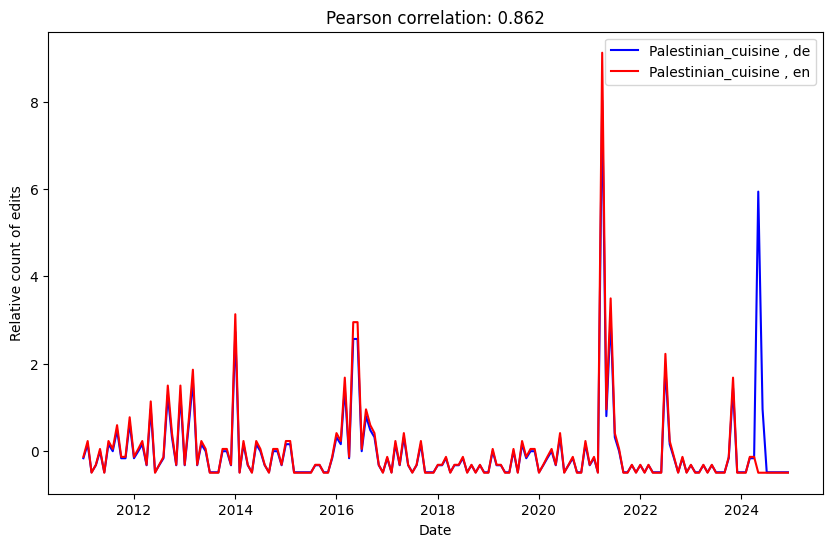

In [81]:
plot_correlation('Palestinian_cuisine', 'de', 'Palestinian_cuisine', 'en', df=wikiData[(wikiData['date'] >= datetime(2011,1,1))])
	

In [57]:
def calculate_correlations(df : pd.DataFrame = wikiData) -> pd.DataFrame:

    correlations = pd.DataFrame(columns=['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value'])
    
    df = df[df['total_edits'] > 0]

    unique_pairs = list(df.drop_duplicates(subset=['article', 'language'])[['article', 'language']].to_records(index=False))

    for c in itertools.combinations(unique_pairs, 2):
        
        try:
 
            correlation = correlation_edits(c[0][0], c[0][1], c[1][0], c[1][1], df=df)
            row = pd.DataFrame({'Article1': [c[0][0]], 'Article2' : [c[1][0]], 'Lang1' : [c[0][1]], 'Lang2' : [c[1][1]], 'Correlation' : [correlation[0]], 'P_value' : [correlation[1]]})
            correlations=pd.concat([correlations, row])
        except:
            continue

    return correlations

def join_topics(topics_df : pd.DataFrame, df : pd.DataFrame) -> pd.DataFrame:
    
    df = pd.merge(df, topics_df, 'left', left_on = 'Article1', right_on = 'Article')[['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value', 'Topic']]
    df = pd.merge(df, topics_df, 'left', left_on = 'Article2', right_on = 'Article', suffixes = ['_1', '_2'])[['Article1', 'Article2', 'Lang1', 'Lang2', 'Correlation', 'P_value', 'Topic_1', 'Topic_2']]

    return df

def determine_group(row):
    
    return_value = ''
    if row['Article1'] == row['Article2'] and row['Lang1'] != row['Lang2']:
        return 'Same Article'
    
    if row['Topic_1'] == row['Topic_2']:
        return_value += 'Same Topic'
        if row['Lang1'] == row['Lang2']:
            return_value += ', Same language '
            
    if return_value == '':
        return_value += 'Nothing common'

    return return_value


def assign_groups(df):

    df['Group'] = df.apply(determine_group, axis=1)
    return df

def correlations_topics_groups(df: pd.DataFrame, topics_df: pd.DataFrame):

    df_correlations = calculate_correlations(df)
    print("Correlations calculated")

    df_topics = join_topics(topics_df, df_correlations)
    print("Topics assigned")

    df_groups = assign_groups(df_topics)
    print("Groups assigned")

    df_groups = df_groups.sort_values('Correlation', ascending = False)
    
    return df_groups

In [51]:
topics = {
    'Ukraine' : 
    ["Kyiv","Kievan_Rus'","Stepan_Bandera","Bohdan_Khmelnytsky","Cossacks","Ukrainian_language","Holodomor","Borscht","Symon_Petliura",
    "Ukrainian_People's_Republic","Mykhailo_Hrushevsky","Nikolai_Gogol","Taras_Shevchenko","Ukrainian_literature","Ivan_Franko","Ukrainian_Insurgent_Army","Organisation_of_Ukrainian_Nationalists","Pierogi",
    "Kolach_(bread)", "Paska_(bread)", "Pampushka", "Syrniki", "Rusyns", "Vyshyvanka", "Ukrainian_Soviet_Socialist_Republic", "Pereiaslav_Agreement", "West_Ukrainian_People's_Republic", 
    "Massacres_of_Poles_in_Volhynia_and_Eastern_Galicia", "Orange_Revolution", "Ukrainian_War_of_Independence", "Principality_of_Kiev", "Kyiv_Pechersk_Lavra","Golden_Gate,_Kyiv", "Bakhchysarai_Palace", 
    "Khreshchatyk", "Kamianets-Podilskyi_Castle",  "Saint_Sophia_Cathedral,_Kyiv", "Kobzar", "Hryhorii_Skovoroda", "Lesya_Ukrainka", "Rus'_people", "Zaporozhian_Cossacks", "Khmelnytsky_Uprising"],

    'Israel/Palestine' : 
    ["Nakba","Mandatory_Palestine","1948_Arab-Israeli_War","David_Ben-Gurion","Yasser_Arafat","Six-Day_War","Yom_Kippur_War","Hummus","Falafel","Shawarma","First_Intifada",
     "United_Nations_Partition_Plan_for_Palestine", "Intercommunal_conflict_in_Mandatory_Palestine", "Lehi_(militant_group)", "Irgun", "Ze'ev_Jabotinsky",
     "Haganah", "1947–1948_civil_war_in_Mandatory_Palestine", "1948_Arab–Israeli_War", "Yitzhak_Rabin", "Palmach", "Moshe_Dayan", "Jewish_exodus_from_the_Muslim_world", 
     "1936–1939_Arab_revolt_in_Palestine", "Amin_al-Husseini", "1948_Palestinian_expulsion_and_flight", "List_of_towns_and_villages_depopulated_during_the_1947–1949_Palestine_war", "Plan_Dalet", 
     "Abd_al-Qadir_al-Husayni", "1929_Hebron_massacre", "Causes_of_the_1948_Palestinian_expulsion_and_flight", "Deir_Yassin_massacre", "Menachem_Begin", "Kfar_Etzion_massacre", "Hebrew_language", 
     "Suez_Crisis", "Six-Day_War", "Egypt–Israel_peace_treaty", "Palestinian_Arabic", "Culture_of_Palestine", "Palestinian_cuisine", "Samih_al-Qasim", "Mahmoud_Darwish", "Origin_of_the_Palestinians"],
    
    
    'US_Civil_War' : 
    ["Ulysses_S._Grant","Sherman's_March_to_the_Sea","William_Tecumseh_Sherman","Union_Army","Confederate_States_Army","Robert_E._Lee","Joseph_E._Johnston","Alexander_H._Stephens","James_Longstreet",
     "United_Daughters_of_the_Confederacy","Army_of_Northern_Virginia","Jefferson_Davis","Origins_of_the_American_Civil_War","Confederate_States_of_America","Abraham_Lincoln","Battle_of_Gettysburg", 
     "Judah_P._Benjamin", "John_C._Breckinridge", "Joseph_Wheeler", "P._G._T._Beauregard", "Franklin_Buchanan", "Nathan_Bedford_Forrest", "Ku_Klux_Klan", "John_C._Frémont", "Joseph_Hooker", "George_Meade", 
     "Wilmington_massacre", "Red_Shirts_(United_States)", "United_Confederate_Veterans", "Confederate_History_Month", "Robert_E._Lee_Day", "Stonewall_Jackson", "Jim_Crow_laws", "John_Brown_(abolitionist)", 
     "William_Lloyd_Garrison", "Frederick_Douglass", "Thaddeus_Stevens", "Battle_of_the_Wilderness", "Battle_of_Antietam", "Reconstruction_era", "Emancipation_Proclamation", 
     "Thirteenth_Amendment_to_the_United_States_Constitution", "Slavery_in_the_United_States", "States'_rights", "Historiographic_issues_about_the_American_Civil_War"],
}

topics_df = pd.DataFrame([(key, value) for key in topics for value in topics[key]], columns=['Topic', 'Article'])

topics_df

,Topic,Article
0,Ukraine,Kyiv
1,Ukraine,Kievan_Rus'
2,Ukraine,Stepan_Bandera
3,Ukraine,Bohdan_Khmelnytsky
4,Ukraine,Cossacks
...,...,...
127,US_Civil_War,Emancipation_Proclamation
128,US_Civil_War,Thirteenth_Amendment_to_the_United_States_Cons...
129,US_Civil_War,Slavery_in_the_United_States
130,US_Civil_War,States'_rights


In [58]:
correlation_500 = correlations_topics_groups(wikiData[(wikiData['total_edits'] > 500) & (wikiData['date'] >= datetime(2011,1,1))], topics_df)


Correlations calculated
Topics assigned
Groups assigned


In [12]:
def summarise_correlations(df):

    print("\n All \n")
    print(df['Group'].value_counts(normalize=True).reset_index())
    print(df['Group'].value_counts().reset_index())
    print("\n >= 0.4 \n")
    print(df[df['Correlation'] >= 0.4]['Group'].value_counts(normalize=True).reset_index())
    print(df[df['Correlation'] >= 0.4]['Group'].value_counts().reset_index())
    print("\n < 0.4 \n")
    print(df[df['Correlation'] < 0.4]['Group'].value_counts(normalize=True).reset_index())
    

In [59]:
summarise_correlations(correlation_500)
correlation_500.head(20)



 All 

                        Group  proportion
0              Nothing common    0.645187
1                  Same Topic    0.214405
2  Same Topic, Same language     0.133412
3                Same Article    0.006996
                        Group  count
0              Nothing common  13096
1                  Same Topic   4352
2  Same Topic, Same language    2708
3                Same Article    142

 >= 0.4 

                        Group  proportion
0              Nothing common    0.462857
1  Same Topic, Same language     0.320000
2                  Same Topic    0.182857
3                Same Article    0.034286
                        Group  count
0              Nothing common     81
1  Same Topic, Same language      56
2                  Same Topic     32
3                Same Article      6

 < 0.4 

                        Group  proportion
0              Nothing common    0.646772
1                  Same Topic    0.214680
2  Same Topic, Same language     0.131789
3            

,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
8489,Thirteenth_Amendment_to_the_United_States_Cons...,Thaddeus_Stevens,en,en,0.864343,1.995379e-51,US_Civil_War,US_Civil_War,"Same Topic, Same language"
17144,Palestinian_cuisine,Palestinian_cuisine,en,de,0.861729,8.686223e-51,Israel/Palestine,Israel/Palestine,Same Article
19733,1948_Palestinian_expulsion_and_flight,1948_Palestinian_expulsion_and_flight,en,de,0.841639,2.804871e-46,Israel/Palestine,Israel/Palestine,Same Article
2864,Ukrainian_War_of_Independence,Khreshchatyk,en,en,0.755428,2.708162e-32,Ukraine,Ukraine,"Same Topic, Same language"
16729,United_Nations_Partition_Plan_for_Palestine,Nakba,en,en,0.751854,2.635310e-09,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
32,Yasser_Arafat,Yasser_Arafat,de,en,0.729063,3.914045e-29,Israel/Palestine,Israel/Palestine,Same Article
2534,First_Intifada,Nakba,en,en,0.716656,3.083912e-08,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"
19832,Jefferson_Davis,Nakba,de,en,0.677436,3.207722e-07,US_Civil_War,Israel/Palestine,Nothing common
3248,James_Longstreet,Massacres_of_Poles_in_Volhynia_and_Eastern_Gal...,en,ru,0.654323,6.717795e-22,US_Civil_War,Ukraine,Nothing common
6272,Yasser_Arafat,Nakba,en,en,0.637433,2.491459e-06,Israel/Palestine,Israel/Palestine,"Same Topic, Same language"


In [80]:
correlation_200.tail()

,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
46339,Organisation_of_Ukrainian_Nationalists,Nakba,en,en,-0.209726,0.166749,Ukraine,Israel/Palestine,Nothing common
32496,Kyiv,Nakba,ru,en,-0.214862,0.156367,Ukraine,Israel/Palestine,Nothing common
7571,States'_rights,Organisation_of_Ukrainian_Nationalists,en,en,-0.215139,0.005101,US_Civil_War,Ukraine,Nothing common
37244,Palestinian_cuisine,Battle_of_Antietam,ar,en,-0.223052,0.003658,Israel/Palestine,US_Civil_War,Nothing common
45759,Ukrainian_People's_Republic,Nakba,en,en,-0.260485,0.083954,Ukraine,Israel/Palestine,Nothing common


In [60]:
correlation_200 = correlations_topics_groups(wikiData[(wikiData['total_edits'] > 200)  & (wikiData['date'] >= datetime(2011,1,1))], topics_df)
all_edits_correlations = correlations_topics_groups(wikiData, topics_df)

Correlations calculated
Topics assigned
Groups assigned
Correlations calculated
Topics assigned
Groups assigned


In [74]:
correlation_200[(correlation_200['Topic_1'] == 'US_Civil_War') & (correlation_200['Lang1'] == 'de') & (correlation_200['Group'] == 'Same Topic, Same language ')]

,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
17082,Confederate_States_of_America,Confederate_States_Army,de,de,0.611466,1.326246e-18,US_Civil_War,US_Civil_War,"Same Topic, Same language"
24296,Ku_Klux_Klan,Abraham_Lincoln,de,de,0.518562,6.017117e-13,US_Civil_War,US_Civil_War,"Same Topic, Same language"
24229,Ku_Klux_Klan,Ulysses_S._Grant,de,de,0.516104,8.064539e-13,US_Civil_War,US_Civil_War,"Same Topic, Same language"
29405,Ulysses_S._Grant,Abraham_Lincoln,de,de,0.438746,2.702123e-09,US_Civil_War,US_Civil_War,"Same Topic, Same language"
6622,Nathan_Bedford_Forrest,Confederate_States_Army,de,de,0.438320,2.810347e-09,US_Civil_War,US_Civil_War,"Same Topic, Same language"
...,...,...,...,...,...,...,...,...,...
34073,Battle_of_Gettysburg,Slavery_in_the_United_States,de,de,-0.078613,3.111069e-01,US_Civil_War,US_Civil_War,"Same Topic, Same language"
4916,Reconstruction_era,Confederate_States_Army,de,de,-0.084716,2.749155e-01,US_Civil_War,US_Civil_War,"Same Topic, Same language"
33591,John_Brown_(abolitionist),Jefferson_Davis,de,de,-0.087648,2.585832e-01,US_Civil_War,US_Civil_War,"Same Topic, Same language"
24366,Ku_Klux_Klan,Jefferson_Davis,de,de,-0.089798,2.470408e-01,US_Civil_War,US_Civil_War,"Same Topic, Same language"


In [61]:
summarise_correlations(correlation_200)
summarise_correlations(all_edits_correlations)



 All 

                        Group  proportion
0              Nothing common    0.638515
1                  Same Topic    0.239969
2  Same Topic, Same language     0.115433
3                Same Article    0.006083
                        Group  count
0              Nothing common  29599
1                  Same Topic  11124
2  Same Topic, Same language    5351
3                Same Article    282

 >= 0.4 

                        Group  proportion
0              Nothing common    0.510836
1  Same Topic, Same language     0.269350
2                  Same Topic    0.191950
3                Same Article    0.027864
                        Group  count
0              Nothing common    165
1  Same Topic, Same language      87
2                  Same Topic     62
3                Same Article      9

 < 0.4 

                        Group  proportion
0              Nothing common    0.639411
1                  Same Topic    0.240306
2  Same Topic, Same language     0.114353
3            

In [63]:
correlation_200.head(10)

,Article1,Article2,Lang1,Lang2,Correlation,P_value,Topic_1,Topic_2,Group
18347,Thirteenth_Amendment_to_the_United_States_Cons...,Thaddeus_Stevens,en,en,0.864343,1.995379e-51,US_Civil_War,US_Civil_War,"Same Topic, Same language"
37318,Palestinian_cuisine,Palestinian_cuisine,en,de,0.861729,8.686223e-51,Israel/Palestine,Israel/Palestine,Same Article
41306,Shawarma,Origin_of_the_Palestinians,ar,en,0.845670,9.852896e-06,Israel/Palestine,Israel/Palestine,Same Topic
44917,1948_Palestinian_expulsion_and_flight,1948_Palestinian_expulsion_and_flight,en,de,0.841639,2.804871e-46,Israel/Palestine,Israel/Palestine,Same Article
13462,Historiographic_issues_about_the_American_Civi...,Origin_of_the_Palestinians,en,en,0.807063,5.165816e-05,US_Civil_War,Israel/Palestine,Nothing common
9502,Samih_al-Qasim,Origin_of_the_Palestinians,ar,en,0.805160,5.551999e-05,Israel/Palestine,Israel/Palestine,Same Topic
4164,William_Tecumseh_Sherman,Origin_of_the_Palestinians,de,en,0.771127,1.792575e-04,US_Civil_War,Israel/Palestine,Nothing common
11377,Kobzar,Nakba,en,en,0.761863,1.214108e-09,Ukraine,Israel/Palestine,Nothing common
46319,Egypt–Israel_peace_treaty,Origin_of_the_Palestinians,ar,en,0.756306,2.814052e-04,Israel/Palestine,Israel/Palestine,Same Topic
7226,Ukrainian_War_of_Independence,Khreshchatyk,en,en,0.755428,2.708162e-32,Ukraine,Ukraine,"Same Topic, Same language"


In [ ]:
print(correlation_200[['Topic_1', 'Topic_2']].value_counts(normalize=True).reset_index())

            Topic_1           Topic_2  proportion
0           Ukraine           Ukraine    0.209897
1  Israel/Palestine           Ukraine    0.161230
2           Ukraine  Israel/Palestine    0.140780
3      US_Civil_War           Ukraine    0.112197
4  Israel/Palestine  Israel/Palestine    0.106718
5           Ukraine      US_Civil_War    0.084110
6      US_Civil_War  Israel/Palestine    0.074963
7  Israel/Palestine      US_Civil_War    0.065234
8      US_Civil_War      US_Civil_War    0.044870


In [ ]:
print(correlation_200[correlation_200['Correlation'] > 0.4][['Topic_1', 'Topic_2']].value_counts(normalize=True).reset_index())

            Topic_1           Topic_2  proportion
0  Israel/Palestine  Israel/Palestine    0.249639
1      US_Civil_War      US_Civil_War    0.222222
2      US_Civil_War  Israel/Palestine    0.170274
3  Israel/Palestine      US_Civil_War    0.125541
4           Ukraine  Israel/Palestine    0.090909
5           Ukraine           Ukraine    0.059163
6      US_Civil_War           Ukraine    0.030303
7           Ukraine      US_Civil_War    0.027417
8  Israel/Palestine           Ukraine    0.024531


### Breakdown by language / topic

In [ ]:
def summarise_correlations(df, lang):

    df = df[(df['Lang1'] == lang) & (df['Lang2'] == lang)]
    print(df[['Group']].value_counts(normalize=True).reset_index())
    print("\n #### \n")
    print(df[df['Correlation'] > 0.4][['Group']].value_counts(normalize=True).reset_index())
    

In [ ]:
summarise_correlations(edit_correlations, 'de')


                        Group  proportion
0              Nothing common      0.6715
1  Same Topic, Same language       0.3285

 #### 

                        Group  proportion
0              Nothing common     0.52381
1  Same Topic, Same language      0.47619


## Burstiness

In [93]:
import matplotlib.pyplot as plt

def calculate_intervals(article : str = None, lang : str = None, topic : str = None, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all) -> pd.Series :

    # get relevant data
    
    filtered_df = edits_df

    if article is not None:
        filtered_df = filtered_df[filtered_df['article'] == article]
    if lang is not None:
        filtered_df = filtered_df[filtered_df['language'] == lang]
    if topic is not None:
        filtered_df = filtered_df[filtered_df['topic'] == topic]
    if timestart is not None:
        filtered_df = filtered_dffiltered_df = filtered_df[filtered_df['language'] == lang][filtered_df['timestamp'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    intervals = filtered_df['timestamp'].diff().dt.total_seconds() / 3600 # convert difference to float representing hours
    
    return intervals[1:] #first value is always NaN

def burstiness(article : str = None, lang : str = None, topic :str = None, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all) -> float:

    intervals = calculate_intervals(article, lang, timestart, timestop, edits_df)

    mean_interval = intervals.mean()
    std_interval = intervals.std()

    return (std_interval - mean_interval) / (std_interval + mean_interval)

In [94]:
unique_articles = wikiData_all.groupby(['article', 'language', 'topic'])['timestamp'].min().reset_index()

unique_articles['edit_frequency'] = 0
unique_articles['edit_frequency_2010'] = 0
unique_articles['burstiness'] = 0
unique_articles['burstiness_2010'] = 0

for index, row in unique_articles.iterrows():
    
    unique_articles.at[index, 'edit_frequency'] = calculate_intervals(row['article'], row['language']).mean()
    unique_articles.at[index, 'edit_frequency_2010'] = calculate_intervals(row['article'], row['language'], datetime(2010,1,1)).mean()
    unique_articles.at[index, 'burstiness'] = burstiness(row['article'], row['language'])
    unique_articles.at[index, 'burstiness_2010'] = burstiness(row['article'], row['language'], datetime(2010,1,1))

unique_articles

,article,language,topic,timestamp,edit_frequency,edit_frequency_2010,burstiness,burstiness_2010
0,1929_Hebron_massacre,ar,Israel/Palestine,2007-07-19 13:55:39,1129.622605,1443.275685,0.213896,0.155639
1,1929_Hebron_massacre,de,Israel/Palestine,2009-07-03 07:57:54,1546.821155,1995.958333,0.172476,0.082215
2,1929_Hebron_massacre,en,Israel/Palestine,2006-08-09 21:43:48,133.639107,223.396681,0.412398,0.310385
3,1936–1939_Arab_revolt_in_Palestine,ar,Israel/Palestine,2007-07-17 18:46:35,327.553763,325.475171,0.318014,0.313324
4,1936–1939_Arab_revolt_in_Palestine,de,Israel/Palestine,2005-02-04 18:53:33,559.758995,645.476246,0.380841,0.359117
...,...,...,...,...,...,...,...,...
366,Zaporozhian_Cossacks,ru,Ukraine,2006-03-24 20:50:58,368.914729,264.764682,0.716322,0.337517
367,Zaporozhian_Cossacks,uk,Ukraine,2008-04-29 14:22:24,1396.998651,1142.961163,0.492293,0.481138
368,Ze'ev_Jabotinsky,ar,Israel/Palestine,2008-02-16 12:07:23,1071.865695,1114.750588,0.179028,0.180364
369,Ze'ev_Jabotinsky,de,Israel/Palestine,2006-05-01 15:43:46,839.555373,504.963518,0.699093,0.325068


In [95]:
unique_articles = unique_articles.merge(wikiData[['topic', 'article', 'language', 'total_edits']].drop_duplicates(), how='left', on=['topic', 'article', 'language'])

In [117]:
import math

def plot_burstiness(article : str = None, lang : str = None, topic : str = None, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all):

    filtered_df = edits_df
    title = []

    if article is not None:
        filtered_df = filtered_df[(filtered_df['article'] == article)]
        title.append(article)
    if lang is not None:
        filtered_df = filtered_df[(filtered_df['language'] == lang)]
        title.append(lang)
    if topic is not None:
        filtered_df = filtered_df[(filtered_df['topic'] == topic)]
        title.append(topic)
    if timestart is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] >= timestart]
    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    plt.figure(figsize=(10, 6))
    fig, ax = plt.subplots()

    lw = 1 / math.sqrt(len(filtered_df) / 100)

    for index, row in filtered_df.iterrows():
        plt.axvline(x=row['timestamp'], color='black', linestyle='-', alpha=0.7, linewidth = lw)
 

    plt.xlabel('Timestamp')
    ax.yaxis.set_visible(False)
    ax.grid(False)
    plt.grid(True)
    plt.title("Edits in time: {a} ({l})".format(a=title[0], l=title[1]))
    plt.tight_layout()

    plt.show()


In [21]:
unique_articles[(unique_articles['timestamp'] < datetime(2010,1,1)) & (unique_articles['total_edits'] > 750)].sort_values('burstiness', ascending=False)

,article,language,topic,timestamp,edit_frequency,edit_frequency_2010,burstiness,burstiness_2010,total_edits
333,Ulysses_S._Grant,en,US_Civil_War,2001-03-29 14:35:19,9.573677,8.633735,0.678912,0.538104,21057.0
47,Confederate_States_Army,de,US_Civil_War,2006-06-07 10:54:02,71.558026,61.311052,0.656728,0.688916,2208.0
31,Battle_of_Antietam,en,US_Civil_War,2002-09-13 15:04:24,33.953084,54.761609,0.616859,0.521379,5560.0
337,United_Daughters_of_the_Confederacy,en,US_Civil_War,2003-02-02 22:46:15,111.179603,80.775506,0.612019,0.455021,1678.0
113,Jefferson_Davis,en,US_Civil_War,2001-09-30 07:33:42,22.970382,23.830803,0.599977,0.495860,8554.0
...,...,...,...,...,...,...,...,...,...
318,Ukrainian_Soviet_Socialist_Republic,en,Ukraine,2003-11-23 17:36:01,91.936950,81.536512,0.289934,0.277858,1934.0
174,Lesya_Ukrainka,ru,Ukraine,2006-01-06 23:35:38,134.102317,118.974229,0.284618,0.284838,1205.0
270,"Saint_Sophia_Cathedral,_Kyiv",uk,Ukraine,2004-12-06 13:05:03,208.078534,187.363094,0.279904,0.278574,819.0
126,Joseph_E._Johnston,en,US_Civil_War,2003-07-10 07:28:53,185.071562,246.055464,0.270507,0.191049,968.0


<Figure size 1000x600 with 0 Axes>

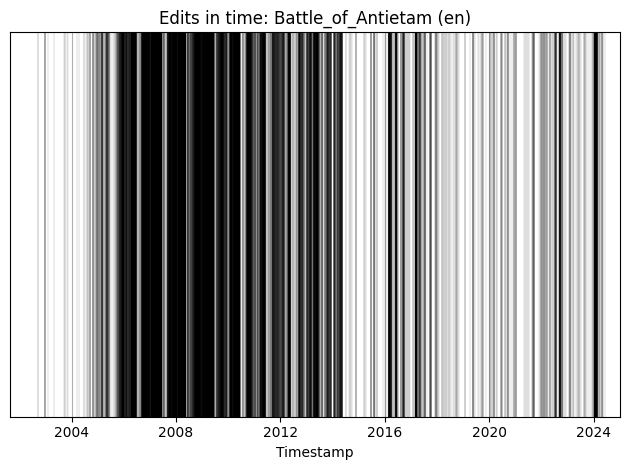

<Figure size 1000x600 with 0 Axes>

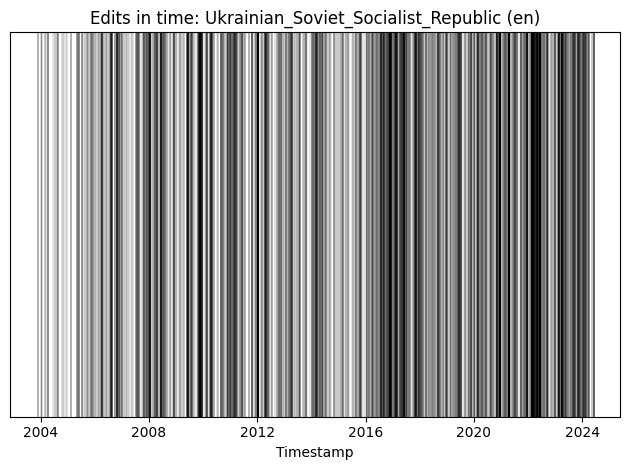

In [118]:
plot_burstiness('Battle_of_Antietam', 'en')
plot_burstiness('Ukrainian_Soviet_Socialist_Republic', 'en')

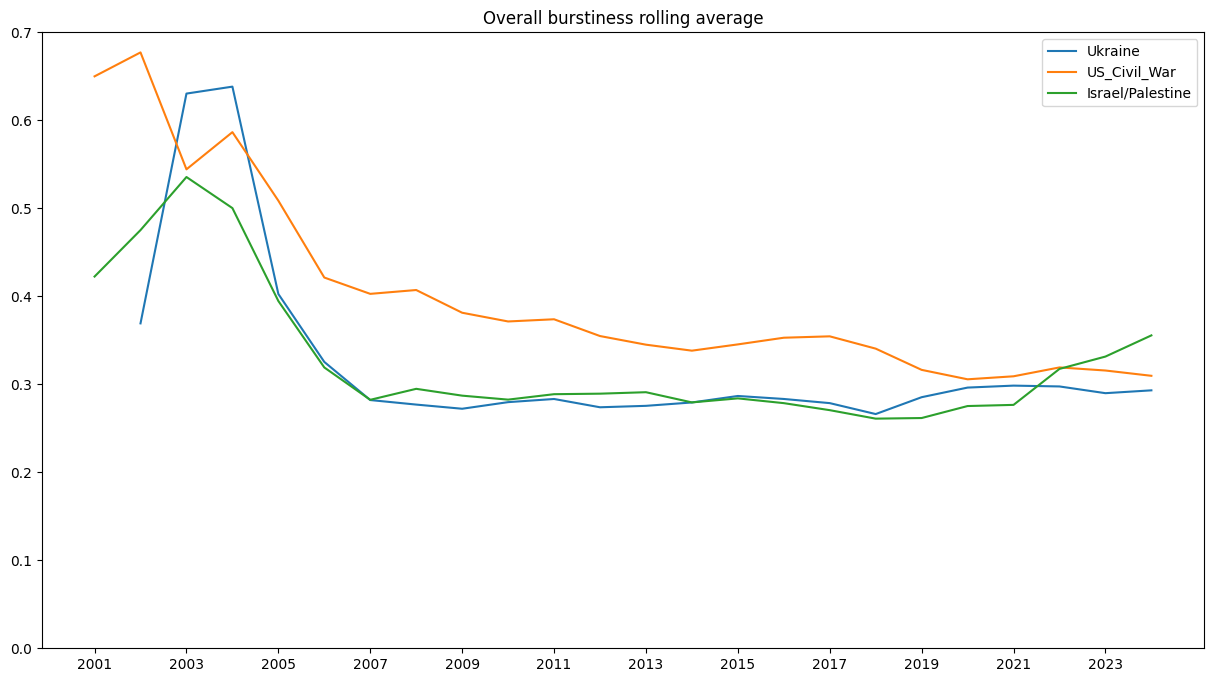

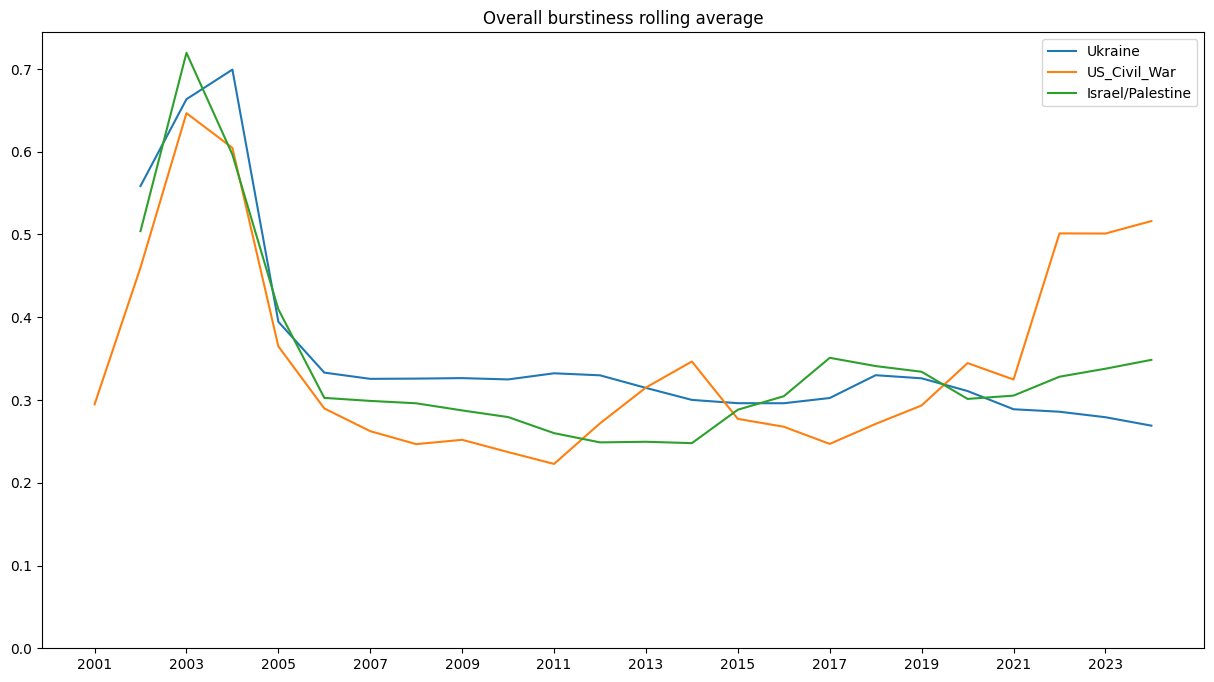

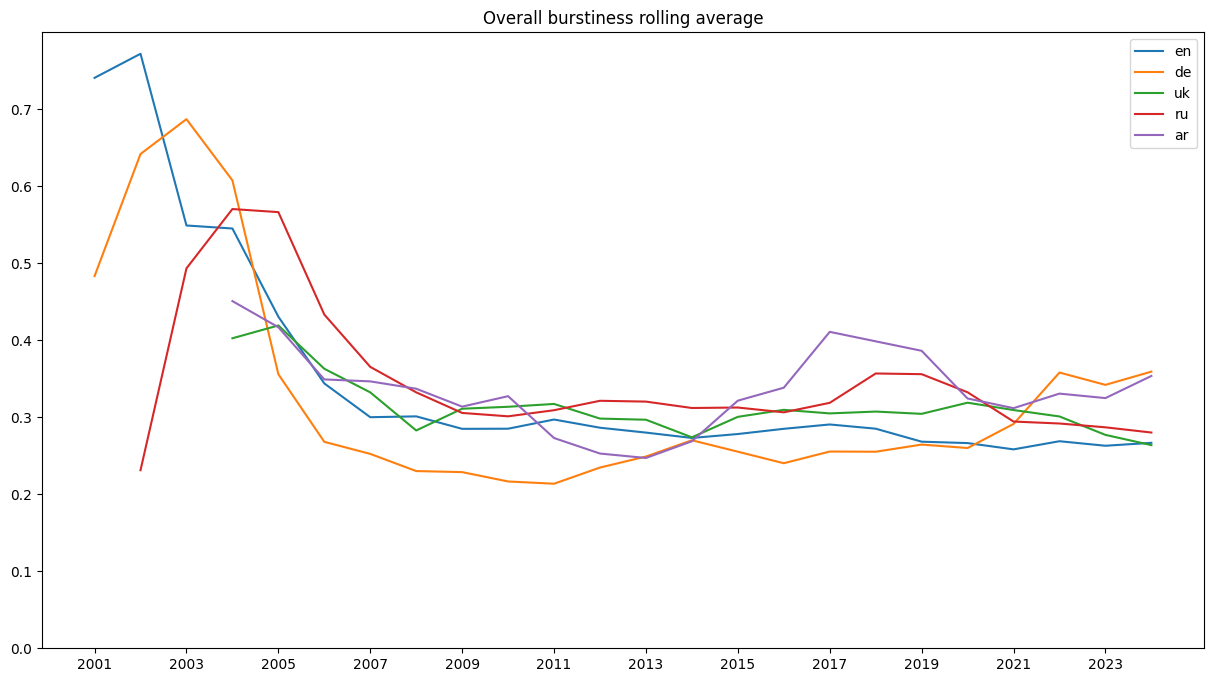

In [159]:
def get_burstiness_in_time(article : str = None, lang : str = None, topic : str = None, edits_df : pd.DataFrame = wikiData_all):

    filtered_df = edits_df

    if article is not None:
        filtered_df = filtered_df[(filtered_df['article'] == article)]

    if lang is not None:
        filtered_df = filtered_df[(filtered_df['language'] == lang)]

    if topic is not None:
        filtered_df = filtered_df[(filtered_df['topic'] == topic)]

    burstiness_dict = {'year' : [], 'burstiness' : []}
    for year in filtered_df['year'].unique():
        df = filtered_df[(filtered_df['year'] == year) | (filtered_df['year'] == year - 1) | (filtered_df['year'] == year + 1)]
        b = burstiness(article, lang, topic, edits_df = df)
        burstiness_dict['year'].append(year)
        burstiness_dict['burstiness'].append(b)
    
    burstiness_df = pd.DataFrame(burstiness_dict)
    return burstiness_df

def plot_burstiness_in_time(group : str = 'language', edits_df : pd.DataFrame = wikiData_all, yearstart : int = None):

    if yearstart is None:
        yearstart = edits_df['year'].min()
    edits_df = edits_df[edits_df['year'] >= yearstart]

    plt.figure(figsize=(15,8))

    for g in edits_df[group].unique():
        df = get_burstiness_in_time(edits_df = edits_df[edits_df[group] == g])
        
        plt.plot(df['year'], df['burstiness'], label=g)
        plt.xticks(range(yearstart, 2025, 2))
        plt.yticks([i / 10 for i in range(0, 8, 1)])
        plt.title("Overall burstiness rolling average")
        plt.legend()
 

plot_burstiness_in_time('topic', wikiData_all[wikiData_all['language'] == 'en'])
plot_burstiness_in_time('topic', wikiData_all[wikiData_all['language'] != 'en'])
plot_burstiness_in_time()

<Figure size 1000x600 with 0 Axes>

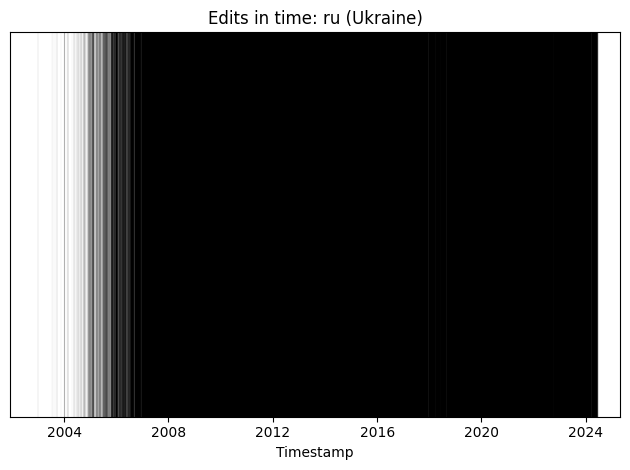

In [113]:
plot_burstiness(lang = 'ru', topic = 'Ukraine')


In [217]:
unique_articles.groupby(['topic', 'language']).agg(
    frequency = ('edit_frequency', 'mean'),
    frequency_2010 = ('edit_frequency_2010', 'mean'),
    burstiness = ('burstiness', 'mean'),
    burstiness_2010 = ('burstiness_2010', 'mean')
).reset_index()


,topic,language,frequency,frequency_2010,burstiness,burstiness_2010
0,Israel/Palestine,ar,599.016678,645.128785,0.295760,0.272465
1,Israel/Palestine,de,662.262451,874.463337,0.352643,0.296928
2,Israel/Palestine,en,435.442203,180.749252,0.453299,0.381181
3,US_Civil_War,de,833.954305,1368.371457,0.356318,0.284516
4,US_Civil_War,en,139.738768,149.773181,0.474783,0.386372
5,Ukraine,de,962.723943,1064.635080,0.310081,0.300229
6,Ukraine,en,277.703935,283.579865,0.373297,0.331592
7,Ukraine,ru,252.140286,257.207716,0.400488,0.374442
8,Ukraine,uk,462.342167,452.813793,0.350066,0.344590


## Burstiness and protections

In [218]:
## Importing and cleaning data (same as protection_analysis.ipynb)

protections_US = pd.read_csv("../data/protection_data/protections_Us_civil_war_2024-06-15-19-46.csv")
protections_US['topic'] = 'US_Civil_War'
protections_UA = pd.read_csv("../data/protection_data/protections_Ukraine_2024-06-15-21-39.csv")
protections_UA['topic'] = 'Ukraine'
protections_IP = pd.read_csv("../data/protection_data/protections_Israel_Palestine_2024-06-15-19-44.csv")
protections_IP['topic'] = 'Israel/Palestine'

protections_all = pd.concat([protections_US, protections_UA, protections_IP]).drop_duplicates()
protections_all['timestamp'] = pd.to_datetime(protections_all['timestamp'])

protections_clean_pm = protections_all[(protections_all['action'] != 'unprotect')].sort_values(['article', 'language', 'timestamp'], ascending=[True, True, True]) # & (protections_all['action'] != 'move_prot')
protections_clean_u = protections_all[protections_all['action'] == 'unprotect']

protections_clean_pm['expiry_mod'] = protections_clean_pm['expiry'].fillna(datetime(2029,12,31))
protections_clean_pm = protections_clean_pm.reset_index()

for index, row in protections_clean_pm.iterrows():

    protections_clean_u_al = protections_clean_u[(protections_clean_u['article'] == row['article']) & (protections_clean_u['language'] == row['language'])]
    protections_clean_u_al = protections_clean_u_al[(protections_clean_u_al['timestamp'] > row['timestamp']) & (protections_clean_u_al['timestamp'] < row['expiry_mod'])]
              

    if len(protections_clean_u_al) > 0:
        
        protections_clean_pm.at[index, 'expiry_mod'] = protections_clean_u_al['timestamp'].min()

protections_cleaned = protections_clean_pm[['article', 'language', 'timestamp', 'expiry', 'expiry_mod', 'user', 'type']].sort_values(['article', 'language', 'timestamp'], ascending=[True, True, True], ignore_index=True)

protections_cleaned['expiry_mod_mod'] = protections_cleaned['expiry_mod']

for index, row in protections_cleaned.iterrows():
    protections_a_l = protections_cleaned[(protections_cleaned['article'] == row['article']) & (protections_cleaned['language'] == row['language'])]
    protections_a_l = protections_a_l[(protections_a_l['timestamp'] > row['timestamp'])]
    
    #if pd.isna(row['type']):
    #    protections_a_l = protections_a_l[pd.isna(protections_a_l['type'])]
    #else:
    #    protections_a_l = protections_a_l[protections_a_l['type'] == row['type']]
    
            
    try:
        protections_a_l = protections_a_l[(protections_a_l['timestamp'] < row['expiry_mod'])]

      
        if len(protections_a_l) > 0:

            protections_cleaned.at[index, 'expiry_mod_mod'] = protections_a_l['timestamp'].min()
        
            
    
    except:
        
        continue


protections_cleaned['expiry_mod'] = pd.to_datetime(protections_cleaned['expiry_mod'])
protections_cleaned['expiry_mod_mod'] = pd.to_datetime(protections_cleaned['expiry_mod_mod'])
protections_cleaned

,article,language,timestamp,expiry,expiry_mod,user,type,expiry_mod_mod
0,1929_Hebron_massacre,en,2007-04-16 16:23:53,2007-04-23 16:23:00,2007-04-23 16:23:00,Thatcher,NaN,2007-04-16 16:34:27
1,1929_Hebron_massacre,en,2007-04-16 16:34:27,2007-04-19 16:34:00,2007-04-19 16:34:00,Thatcher,NaN,2007-04-19 16:34:00
2,1929_Hebron_massacre,en,2007-10-16 20:55:51,2007-10-23 20:55:00,2007-10-23 20:55:00,Penwhale,NaN,2007-10-23 20:55:00
3,1929_Hebron_massacre,en,2014-07-24 20:00:31,2014-08-07 20:00:00,2014-08-07 20:00:00,NawlinWiki,NaN,2014-08-07 20:00:00
4,1929_Hebron_massacre,en,2019-04-29 20:40:37,2029-12-31 23:59:59,2029-12-31 23:59:59,Oshwah,"['edit', 'move']",2029-12-31 23:59:59
...,...,...,...,...,...,...,...,...
1079,Zaporozhian_Cossacks,ru,2022-04-25 19:17:52,2022-05-02 19:17:00,2022-05-02 19:17:00,QBA-bot,"['edit', 'move']",2022-05-02 19:17:00
1080,Zaporozhian_Cossacks,ru,2023-09-27 11:06:22,2023-10-04 11:06:00,2023-10-04 11:06:00,QBA-bot,"['edit', 'move']",2023-10-04 11:06:00
1081,Ze'ev_Jabotinsky,en,2019-11-30 00:27:08,2019-12-30 00:27:00,2019-12-30 00:27:00,Berean Hunter,['edit'],2019-12-30 00:27:00
1082,Ze'ev_Jabotinsky,en,2024-05-02 09:42:26,2024-06-02 09:42:00,2024-05-02 19:34:55,Doug Weller,"['edit', 'move']",2024-05-02 19:34:55


In [219]:
import math

def plot_burstiness_protection(article : str, lang : str, timestart : datetime = None, timestop : datetime = None, edits_df : pd.DataFrame = wikiData_all, protections : pd.DataFrame = protections_cleaned):

    filtered_df = edits_df[(edits_df['article'] == article) & (edits_df['language'] == lang)]
    filtered_protections = protections[(protections['article'] == article) & (protections['language'] == lang)]

    if timestart is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] >= timestart]
        filtered_protections = protections[protections['timestamp'] >= timestart]

    if timestop is not None:
        filtered_df = filtered_df[filtered_df['timestamp'] <= timestop]
        filtered_protections = protections[protections['timestamp'] <= timestop]

    filtered_df = filtered_df.sort_values('timestamp')

    plt.figure(figsize=(10, 6))
    lw = 1 / math.sqrt(len(filtered_df) / 100)

    for index, row in filtered_df.iterrows():
        plt.axvline(x=row['timestamp'], color='black', linestyle='-', alpha=0.7, linewidth = lw)
        
    for index, row in filtered_protections.iterrows():
        start = row['timestamp']
        end = row['expiry_mod_mod']
        plt.axvspan(start, end, color='red', alpha=0.3, label='Protected')

    plt.xlabel('Timestamp')
    plt.grid(True)
    plt.tight_layout()

    plt.show()


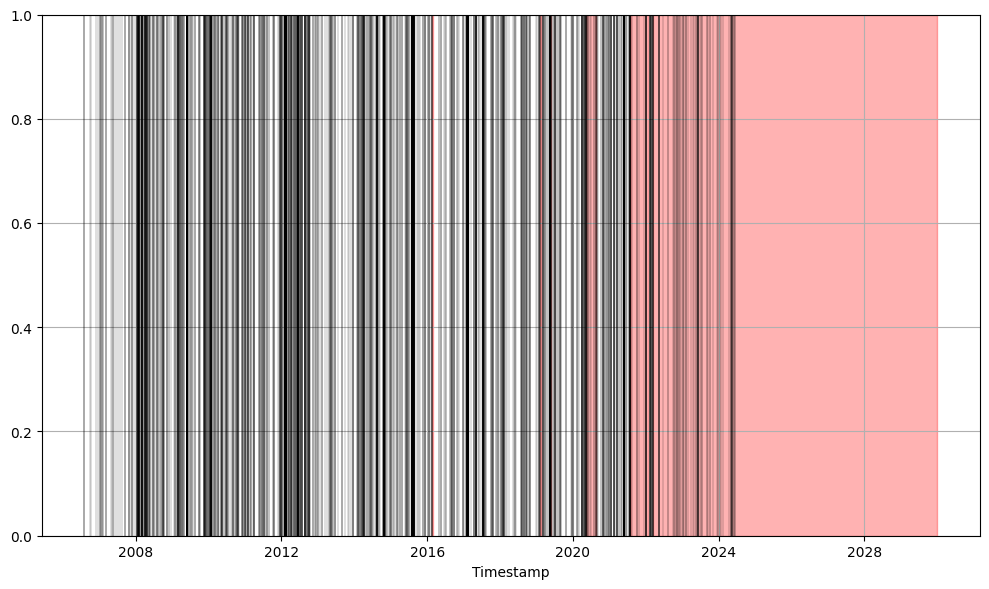

In [220]:
plot_burstiness_protection("Ukrainian_People's_Republic", 'ru')

In [221]:
protections_cleaned[protections_cleaned['article'] == "Ukrainian_People's_Republic"]

,article,language,timestamp,expiry,expiry_mod,user,type,expiry_mod_mod
954,Ukrainian_People's_Republic,en,2013-11-20 15:33:25,2014-02-20 15:33:00,2014-02-20 15:33:00,NawlinWiki,NaN,2014-02-20 15:33:00
955,Ukrainian_People's_Republic,en,2018-06-01 17:35:32,2018-06-08 17:35:00,2018-06-08 17:35:00,IronGargoyle,"['edit', 'move']",2018-06-08 17:35:00
956,Ukrainian_People's_Republic,en,2022-11-29 21:53:03,2029-12-31 23:59:59,2029-12-31 23:59:59,Ymblanter,"['edit', 'move']",2029-12-31 23:59:59
957,Ukrainian_People's_Republic,ru,2016-02-18 18:12:46,2016-02-25 18:12:00,2016-02-25 18:12:00,Wulfson,['edit'],2016-02-25 18:12:00
958,Ukrainian_People's_Republic,ru,2019-02-04 12:53:24,2019-02-18 12:53:00,2019-02-18 12:53:00,Deinocheirus,"['edit', 'move']",2019-02-18 12:53:00
959,Ukrainian_People's_Republic,ru,2019-05-20 16:04:31,2019-05-27 16:04:00,2019-05-27 16:04:00,Wulfson,"['edit', 'move']",2019-05-27 16:04:00
960,Ukrainian_People's_Republic,ru,2020-05-15 07:09:50,2020-08-15 07:09:00,2020-08-15 07:09:00,Wulfson,"['edit', 'move']",2020-08-15 07:09:00
961,Ukrainian_People's_Republic,ru,2021-07-22 09:37:04,2021-07-29 09:37:00,2021-07-29 09:37:00,QBA-bot,"['edit', 'move']",2021-07-22 09:59:02
962,Ukrainian_People's_Republic,ru,2021-07-22 09:59:02,2022-01-22 09:58:00,2022-01-22 09:58:00,Lesless,"['edit', 'move']",2022-01-22 09:58:00
963,Ukrainian_People's_Republic,ru,2022-03-14 13:09:04,2029-12-31 23:59:59,2029-12-31 23:59:59,Oleg Yunakov,"['edit', 'move']",2029-12-31 23:59:59
